<a href="https://colab.research.google.com/github/sepehrsardooeinasab/Face_Boundry_and_Facial_Landmark_Detection/blob/master/part3_face_boundary_and_facial_landmark_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Boundary and Facial Landmark Detection

## Config google collab

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## Import neccessary packages

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

## Global variables

In [3]:
BASE_PATH = r'/content/drive/MyDrive/CV2022/'
NEW_WIDTH_HEIGHT = 224

## Load rcnn model

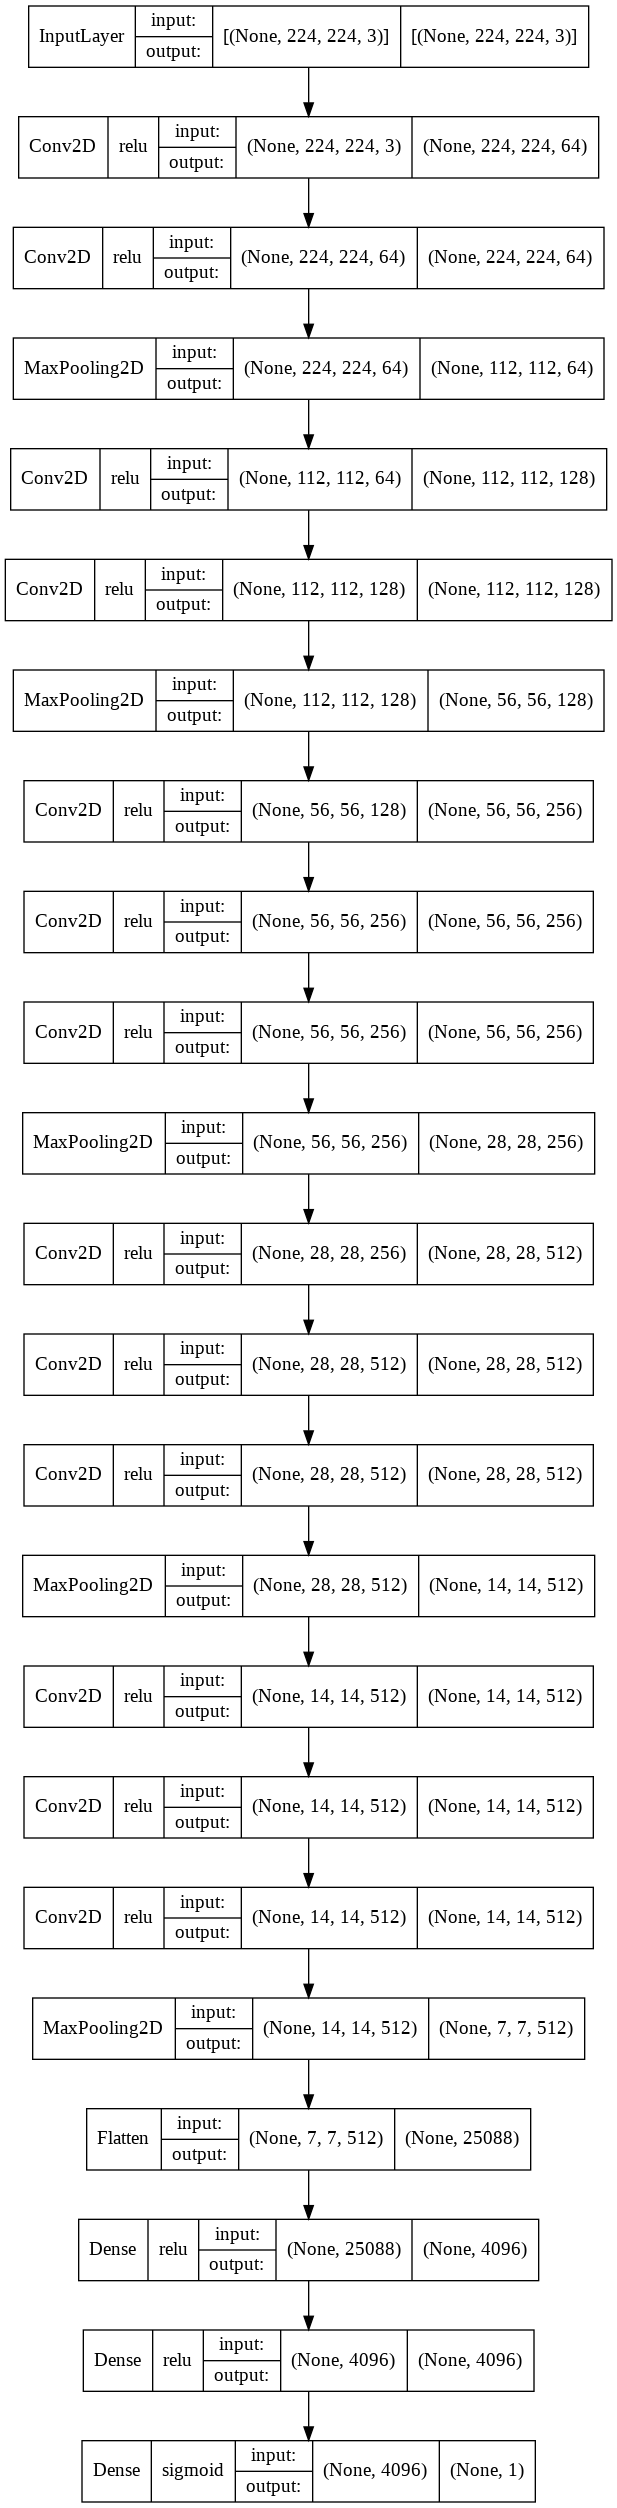

In [4]:
model_bb = load_model(BASE_PATH + "Models/VGG16_BB")
plot_model(model_bb, show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='TB')

## Load cnn model

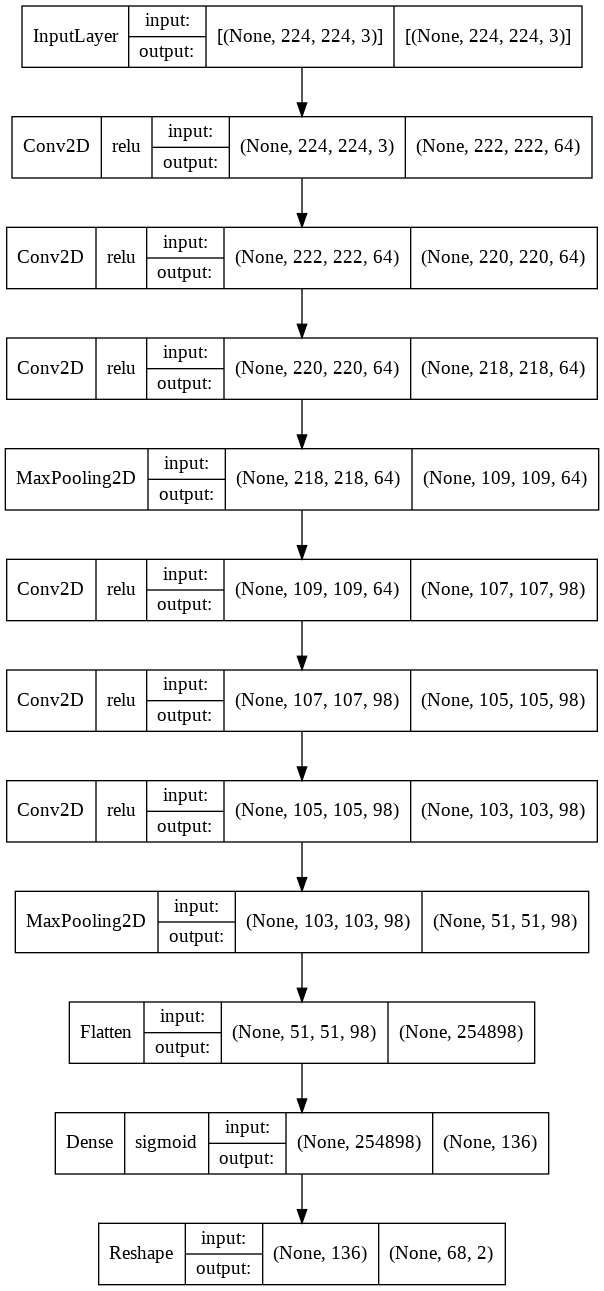

In [5]:
model_lm = load_model(BASE_PATH + "Models/CNN_LM.h5")
plot_model(model_lm, show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='TB')

## OpenCV selective search

In [6]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

## Calculate intersection over union

In [7]:
def calculate_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Test an image

In [8]:
def test_image(address, show_all=False):
    image = cv2.imread(address)

    print('Original image')
    plt.figure(figsize=(15, 7))
    plt.imshow(image[:,:,::-1])
    plt.show()

    current_height, current_width = image.shape[0], image.shape[1]
    resized_image = cv2.resize(image, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))

    ss.setBaseImage(resized_image)
    ss.switchToSelectiveSearchFast()
    ss_results = ss.process()
    resized_image_copy = resized_image.copy() / 255.0

    bbs = []
    for i, result in enumerate(ss_results):
        if i < 500:
            x, y, w, h = result
            timage = resized_image_copy[y:y+h, x:x+w]
            resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
            resized = np.expand_dims(resized, axis=0)
            predicted = model_bb.predict(resized)
            if (predicted[0] > 0.7):
                bbs.append([x, y, w, h])
        
    best_bbs = []
    flag = 0
    for i, box1 in enumerate(bbs):
        x1, y1, w1, h1 = box1
        for box2 in bbs[i+1:]:
            x2, y2, w2, h2 = box2
            if calculate_iou({"x1":x1, "x2":x1+w1, "y1":y1, "y2":y1+h1},
                             {"x1":x2, "x2":x2+w2, "y1":y2, "y2":y2+h2}) > 0.3:
                flag = 1
        if flag == 0:
            best_bbs.append(box1)
        flag = 0

    faces = []
    for box in best_bbs:
        x, y, w, h = box
        timage = resized_image_copy[y:y+h, x:x+w]
        resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
        faces.append(resized)

    faces_landmarks = []
    for face in faces:
        landmarks = (model_lm.predict(np.expand_dims(face, axis=0)) * NEW_WIDTH_HEIGHT).astype(int)
        faces_landmarks.append(landmarks)

    faces_landmarks_new_width_height = []
    for i in range(len(faces_landmarks)):
        face_landmarks_new_width_height = []
        for j in range(len(faces_landmarks[i][0])):
            x = int(best_bbs[i][0] + ((best_bbs[i][2]/NEW_WIDTH_HEIGHT) * faces_landmarks[i][0][j][0]))
            y = int(best_bbs[i][1] + ((best_bbs[i][3]/NEW_WIDTH_HEIGHT) * faces_landmarks[i][0][j][1]))
            face_landmarks_new_width_height.append([x, y])
        faces_landmarks_new_width_height.append(face_landmarks_new_width_height)

    faces_landmarks_original = []
    for i in range(len(faces_landmarks_new_width_height)):
        face_landmarks_original = []
        for j in range(len(faces_landmarks_new_width_height[i])):
            x = int(current_width / NEW_WIDTH_HEIGHT * faces_landmarks_new_width_height[i][j][0])
            y = int(current_height / NEW_WIDTH_HEIGHT * faces_landmarks_new_width_height[i][j][1])
            face_landmarks_original.append([x, y])
        faces_landmarks_original.append(face_landmarks_original)
    
    best_bbs_original = []
    for i in range(len(best_bbs)):
        bb_original = []
        for j in range(0, len(best_bbs[i]), 2):
            bb_original.append(int((current_width / NEW_WIDTH_HEIGHT) * best_bbs[i][j]))
            bb_original.append(int((current_height / NEW_WIDTH_HEIGHT) * best_bbs[i][j+1]))
        best_bbs_original.append(bb_original)

    if show_all:
        print('\nResized image')
        plt.figure(figsize=(15, 7))
        plt.imshow(resized_image_copy[:,:,::-1])
        plt.show()

        print('\nResized image with estimated face boundries')
        plt.figure(figsize=(15, 7))
        resized_image_copy2 = resized_image_copy.copy()
        for box in best_bbs:
            x, y, w, h = box
            cv2.rectangle(resized_image_copy2, (x,y), (x+w,y+h), (0,0,1), 1, cv2.LINE_AA)
        plt.imshow(resized_image_copy2[:,:,::-1])
        plt.show()

        print('\nResized faces')
        faces_copy = faces.copy()
        fig, subplots = plt.subplots(1, len(faces_copy), figsize=(15, 9))
        for e, ax in enumerate(subplots):
            ax.imshow(faces_copy[e][:,:,::-1])
        plt.show()

        print('\nResized faces with estimated landmarks')
        faces_copy = faces.copy()
        for e, face in enumerate(faces_copy):
            for landmark in faces_landmarks[e][0]:
                cv2.circle(face, (landmark[0], landmark[1]),
                           radius=2, color=(0,1,0), thickness=-1)
        fig, subplots = plt.subplots(1, len(faces_copy), figsize=(15, 9))
        for e, ax in enumerate(subplots):
            ax.imshow(faces_copy[e][:,:,::-1])
        plt.show()

        print('\nResized image with estimated face boundries and landmarks')
        plt.figure(figsize=(15, 7))
        resized_image_copy3 = resized_image_copy2.copy()
        for i in range(len(faces)):
            for landmark_face in faces_landmarks_new_width_height[i]:
                for j in range(68):
                    cv2.circle(resized_image_copy3, (landmark_face[0], landmark_face[1]),
                               radius=1, color=(0,1,0), thickness=-1)
        plt.imshow(resized_image_copy3[:,:,::-1])
        plt.show()

    print('\nOriginal image with estimated face boundries and landmarks')
    plt.figure(figsize=(15, 7))
    image_copy = image.copy()
    for box in best_bbs_original:
        x, y, w, h = box
        cv2.rectangle(image_copy, (x,y), (x+w,y+h), (0,0,255), 5, cv2.LINE_AA)
    for face in faces_landmarks_original:
        for i in range(len(faces)):
            for landmark_face in faces_landmarks_original[i]:
                for j in range(68):
                    cv2.circle(image_copy, (landmark_face[0], landmark_face[1]),
                               radius=3, color=(0,255,0), thickness=-1)
    plt.imshow(image_copy[:,:,::-1])
    plt.show()

<code>show_all = False</code> to see only original picture before and after face boundy and facial landmark detection


Saving Test_18.jpg to Test_18.jpg
 
Original image


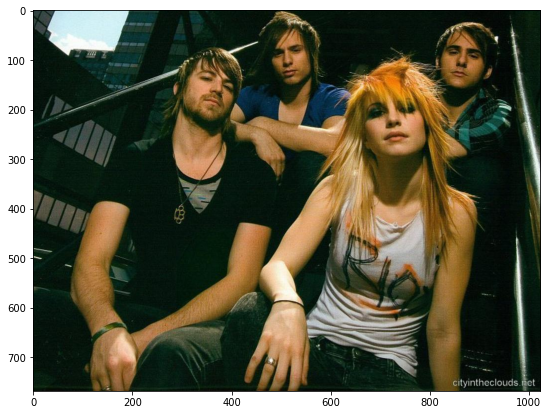


Resized image


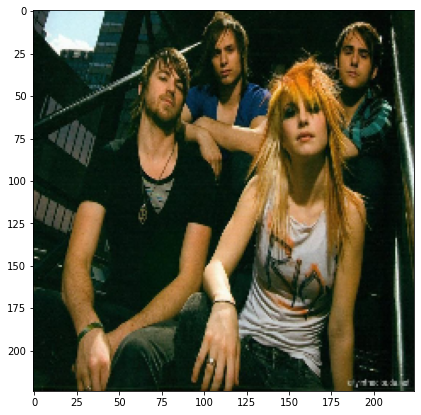


Resized image with estimated face boundries


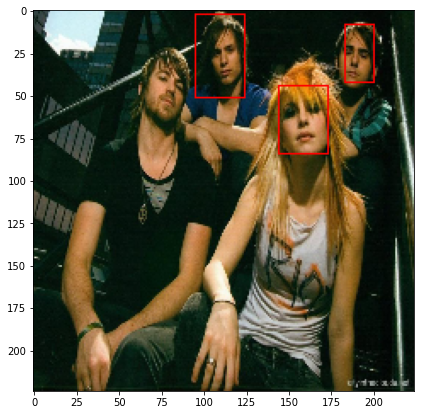


Resized faces


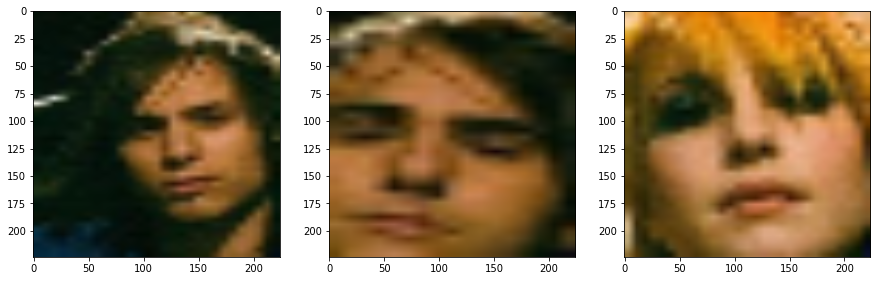


Resized faces with estimated landmarks


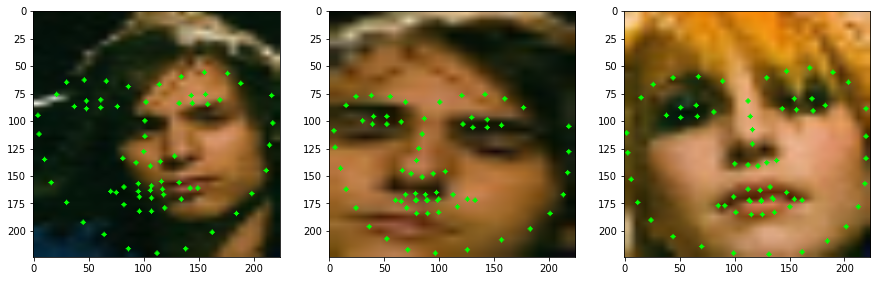


Resized image with estimated face boundries and landmarks


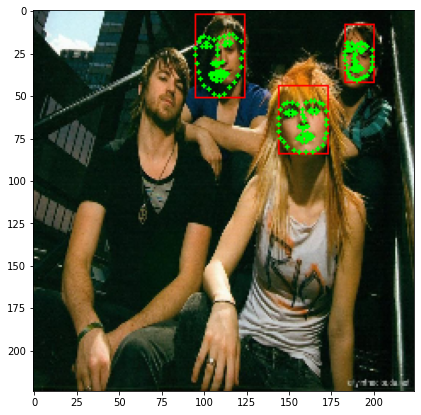


Original image with estimated face boundries and landmarks


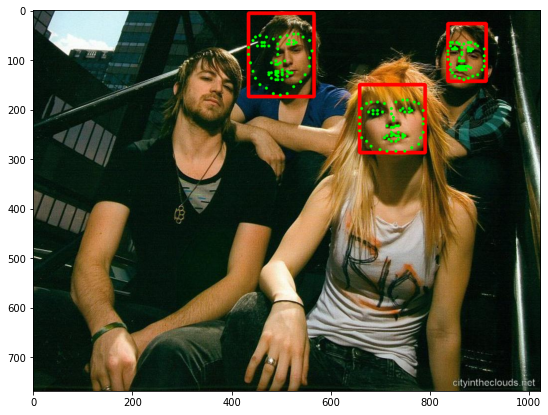

In [9]:
uploaded = files.upload()
show_all = True

for e, image in enumerate(uploaded):
    try:
        print(" ")
        test_image(image, show_all=show_all)
    except:
        print("An exception occurred for file %d\n"%e)